# Using Nilearn for statistical analysis of fMRI data in BIDS format

This tutorial is based on [this analysis](https://nilearn.github.io/stable/auto_examples/07_advanced/plot_bids_analysis.html).
 and [this analysis](https://nilearn.github.io/dev/auto_examples/00_tutorials/plot_single_subject_single_run.html#sphx-glr-auto-examples-00-tutorials-plot-single-subject-single-run-py) presented on the Nilearn web-page.
 
## What is Nilearn?
Nilearn is one of the packages in the growing ["nipy" ecosystem](https://nipy.org/) of Python packages for neuroimaging analysis (see also [MNE](https://mne.tools/stable/index.html), [nistats](https://nistats.github.io/), [nipype](https://nipype.readthedocs.io/en/latest), [nibabel](https://nipy.org/nibabel/), [NiPreps](https://www.nipreps.org), and [dipy](http://dipy.org/)). Specifically, Nilearn provides tools for analysis techniques like functional connectivity, multivariate (machine-learning based) "decoding", but also more "basic" tools like image manipulation and visualization.

<div class="alert alert-success" role="alert">

# Preamble: Activate environment
In the first notebook, we installed a python environment. If you haven't don so, please go back to the ```01_setup_virtual_environment.ipynb``` and complete this before proceeding.

If you closed/stopped the UCloud run between then and now, we will need to reactivate the environment.

For this we use a bash script with a subset of the lines we used for setting up the environment

The script called ```activate.sh``` This should be located in your working directory. If not, save the following in a file with this filename.

```bash
. /work/<MY DIRECTORY NUMBER>/virt_env/bin/activate
python -m ipykernel install --user --name=virt_env
echo Done! Remember changing the kernel in Jupyter.
```
</div>

In [1]:
import os
path='/work/798873' # Remember to change this to your own path
os.chdir(path)
!./activate.sh


Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


<div class="alert alert-success" role="alert">
    
### Check that we are in the right environment

</div>

In [1]:
import sys
print(sys.executable)
#Check that we have something installed.
import nilearn

/work/798873/virt_env/bin/python



# BIDS dataset first and second level analysis


The tutorial contains step-by-step example of fitting a `GLM` to perform a first (single subject) and second level (group) analysis in a `BIDS` dataset and visualizing the results.

#### Brain Imaging Data Structure (BIDS)
`BIDS`is a particular convention for storing neuroimaging data, which makes it easier to reproduce and share analyses:

![img](https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fsdata.2016.44/MediaObjects/41597_2016_Article_BFsdata201644_Fig1_HTML.jpg)

Details about the `BIDS` standard can be consulted at
[http://bids.neuroimaging.io](http://bids.neuroimaging.io/).



## In this tutorial, we will:

1. Download an fMRI `BIDS` dataset with two language conditions to contrast (reading sentences and letter strings).
2. Extract first level (single subject) model objects automatically from the `BIDS` dataset.
3. Investigate the model and plot it design matrix, contrasts and effects.
4. Fit a second level (group) model on the fitted first level models. Notice that
   in this case the preprocessed `BOLD` images were already normalized to the
   same `MNI` space.
5. Plot the results in different ways to show some of the possibilities in Nilearn.


In [2]:
# import some functionality

import os
import pip
#import os.path as op
#import numpy as np
#from numpy.linalg import inv
#import nibabel as nib
import matplotlib.pyplot as plt
#from scipy.ndimage import gaussian_filter

%matplotlib inline

## Fetch example BIDS dataset
We download a simplified `BIDS` dataset made available for illustrative
purposes. It contains only the necessary
information to run a statistical analysis using Nilearn. The raw data
subject folders only contain events.tsv files, while the
derivatives folder includes the preprocessed files preproc.nii and the
confounds.tsv files.



In [3]:
from nilearn.datasets import fetch_language_localizer_demo_dataset
data_dir, _ = fetch_language_localizer_demo_dataset()



Dataset created in /home/ucloud/nilearn_data/fMRI-language-localizer-demo-dataset



Downloaded 743759872 of 749503182 bytes (99.2%,    0.1s remaining) ...done. (20 seconds, 0 min)
Extracting data from /home/ucloud/nilearn_data/fMRI-language-localizer-demo-dataset/fMRI-language-localizer-demo-dataset.zip..... done.


In [4]:
print('Here is the location of the dataset on disk:', data_dir)

Here is the location of the dataset on disk: /home/ucloud/nilearn_data/fMRI-language-localizer-demo-dataset


### Investigating the BIDS structure
Let's make a function to see what this folder contains.

In [5]:
def list_files(startpath):
    """ Simple function to show directory tree. 
    From: https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python. """
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print('{}{}'.format(subindent, f))
            
list_files(data_dir)

fMRI-language-localizer-demo-dataset/
    .bidsignore
    CHANGES
    README
    access_data.py
    dataset_description.json
    participants.tsv
    sub-09/
        func/
            sub-09_task-languagelocalizer_events.tsv
    sub-05/
        func/
            sub-05_task-languagelocalizer_events.tsv
    sub-07/
        func/
            sub-07_task-languagelocalizer_events.tsv
    sub-02/
        func/
            sub-02_task-languagelocalizer_events.tsv
    sub-10/
        func/
            sub-10_task-languagelocalizer_events.tsv
    sub-08/
        func/
            sub-08_task-languagelocalizer_events.tsv
    sub-03/
        func/
            sub-03_task-languagelocalizer_events.tsv
    derivatives/
        dataset_description.json
        sub-09/
            func/
                sub-09_task-languagelocalizer_desc-confounds_regressors.tsv
                sub-09_task-languagelocalizer_desc-preproc_bold.json
                sub-09_task-languagelocalizer_desc-preproc_bold.nii.gz
 

### What is in the BIDS folder?
This `BIDS` dataset folder contains different mandatory elements ([http://bids.neuroimaging.io](http://bids.neuroimaging.io/)). These include:
- A folder for each participant, e.g. `sub-01`. This contains a subfolder called `func` where the raw BOLD data is usually stored along with a `.tsv` file describing the events (experimental design) of the particular scan. In this dataset the raw data has been left out. Also the `anat`folder, which normally contains anatomical scans have been left out.
- A folder called `derivatives` which is used to store processed data. In this dataset, we will can find preprocessed data files `preproc_bold.nii` and the `confounds_regressors.tsv` files (which contains the motion parameters from the spatial realignment. 
- A number of `.json` files with meta-data.

NB. All the filenames contain a description of the particular experiment.

## Obtain automatically FirstLevelModel objects and fit arguments
From the dataset directory we automatically obtain the FirstLevelModel objects
with their subject_id filled from the :term:`BIDS` dataset. Moreover, we obtain
for each model a dictionary with run_imgs, events and confounder regressors
since in this case a confounds.tsv file is available in the :term:`BIDS` dataset.
To get the first level models we only have to specify the dataset directory
and the task_label (`languagelocalizer`) as specified in the file names.



In [6]:
from nilearn.glm.first_level import first_level_from_bids
task_label = 'languagelocalizer'
models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label,
        img_filters=[('desc', 'preproc')])

/work/798873/virt_env/lib/python3.10/site-packages/nilearn/interfaces/bids/query.py:46: UserWarning: 'StartTime' not found in file /home/ucloud/nilearn_data/fMRI-language-localizer-demo-dataset/derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-preproc_bold.json.
  warn(f"'{field}' not found in file {json_files[0]}.")
/work/798873/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1017: UserWarning: 'slice_time_ref' not provided and cannot be inferred from metadata.It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models.
  warn("'slice_time_ref' not provided "


### What just happened?
A lot happened in a few lines of code. That is great, but also confusing.
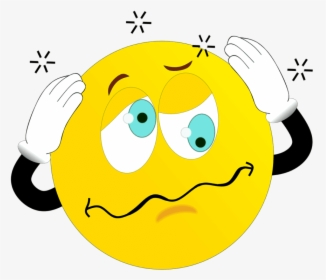

What did the function actually do? Let's look into the `first_level_from_bids` function.

In [7]:
#What does the `first_level_from_bid` function take as arguments?
import inspect
import pandas as pd
#Get the argument from the function
args=inspect.getfullargspec(first_level_from_bids)

#Make a dataframe to display arguments (skip the first two ('dataset_path' and 'task_label') that have no defaults
df = pd.DataFrame(args.defaults,args.args[2:])

#You don't have to use the print() function for Pandas.
df

#Same info can also be obtained by writing "first_level_from_bids?"

,0
space_label,None
sub_labels,None
img_filters,None
t_r,None
slice_time_ref,0.0
hrf_model,glover
drift_model,cosine
high_pass,0.01
drift_order,1
fir_delays,[0]


Here, we can see that the function uses information about `t_r` (TR), `HRF_model` (hemodynamic response function),``drift_model`` and `high_pass` (both used for high-pass filtering), `noise_model`(used for modelling auto correlation). In other words, this function seems to implement all the elements, we have been going through in previous tutorials.

<b>Nice stuff!</b>

## Quick sanity check on fit arguments
Additional checks or information extraction from pre-processed data can
be made here.



As, we have seen from the folder inspection, we only have one run_img per subject.



In [8]:
import os
#Get the file names for subj01 functional data
func01=([os.path.basename(run) for run in models_run_imgs[0]])
print(func01)



['sub-03_task-languagelocalizer_desc-preproc_bold.nii.gz']


Let's load this file and inspect the data.

In [9]:
from nilearn import image

#Get the full path
func01_path=([os.path.abspath(run) for run in models_run_imgs[0]])
#Load the image and inspect data size
func_img = image.load_img(func01_path)
print("Shape of functional MRI image: %s" % (func_img.shape,))

Shape of functional MRI image: (45, 53, 43, 229)


As we see, the data contains 229 volumes with a 45 x 53 x43 voxel resolution.

In [10]:
print(models[0])

FirstLevelModel(subject_label='03', t_r=1.5)


Here, we see that the model is a `FirstLevelModel` object ([See here for details](https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.FirstLevelModel.html)). This means that it incorporates all the same default values for setting up and estimating GLM-fMRI models as in the `first_level_from_bids`, unless else is mentioned. 

Here, we see the additional information that data were obtained with a TR of 1.5 seconds.


Let's inspect what we find in the `models_confounds` variable.

In [11]:
print(models_confounds[0][0].columns)

Index(['RotX', 'RotY', 'RotZ', 'X', 'Y', 'Z'], dtype='object')


The only confounds stored are regressors obtained from motion correction. As
we can verify from the column headers of the confounds table corresponding
to the only run_img present. These correspond to the rotations and translations, we covered in the `09_fMRI_preprocessing2_spatial.ipynb` tutorial.

Let's see what is in the `models_events`variable:



In [12]:
print(type(models_events[0]))

print(models_events[0])

<class 'list'>
[      onset  duration trial_type
0     3.518     6.801   language
1    17.708     6.800     string
2    32.006     6.801   language
3    46.304     7.001     string
4    60.606     6.802   language
5    74.909     6.805     string
6    89.202     6.801   language
7   103.504     6.801     string
8   117.802     6.800   language
9   132.101     7.202     string
10  146.401     6.804   language
11  160.708     6.802     string
12  175.007     6.803   language
13  189.302     6.803     string
14  203.607     6.806   language
15  217.904     6.803     string
16  232.207     6.803   language
17  246.510     6.800     string
18  260.801     6.805   language
19  275.105     6.801     string
20  289.407     6.802   language
21  303.707     6.802     string
22  318.007     6.802   language
23  332.302     6.803     string]


The function has loaded the `...events.tsv` file, which contains information about the experiment and has put it in a list variable.

Here, we can see that the experiment used a <b>block design</b> where each block lasted *6.8 seconds*.

During the experiment, the subject read blocks of *sentences* and
*consonant strings*. 

So these are our only two conditions in events.

We can see check how many blocks were in each condition:

In [13]:
print(models_events[0][0]['trial_type'].value_counts())

trial_type
language    12
string      12
Name: count, dtype: int64


12 blocks of each!

## First level (single subject) model estimation
Now, that we have seen that if we have a correctly structured BIDS dataset, the `first_level_from_bids` function gathers everything we need for analysis, we can get going with the analysis.

### Analysing one participant

We will start by analysing the data from the first participant and generating a report of the process and the results.

If we have a [`FirstLevelModel`](https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.FirstLevelModel.html) class object as we have created above, we can use the variable.fit() function to pair the `FirstLevelModel`object with the additionally needed information (e.g. functional images, events and a matrix of confounding variables), assemble the model and estimate it.

In [22]:

# Get data and model info for 1st participant
model1=models[0]
imgs1=models_run_imgs[0]
events1=models_events[0]
confounds1=models_confounds[0]

#Fit the model
model1.fit(imgs1,events1,confounds1)

03


### Plotting the design matrix
We will then use the `plot_design_matrix`function to give the model a sanity check. 

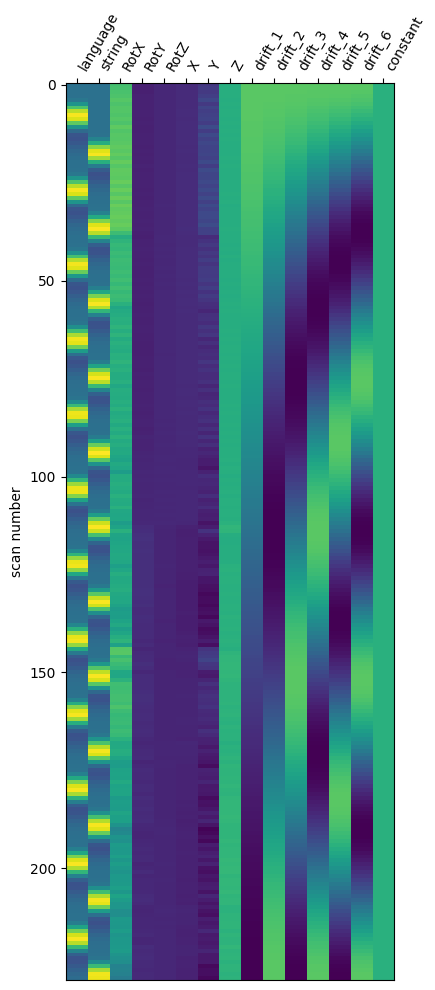

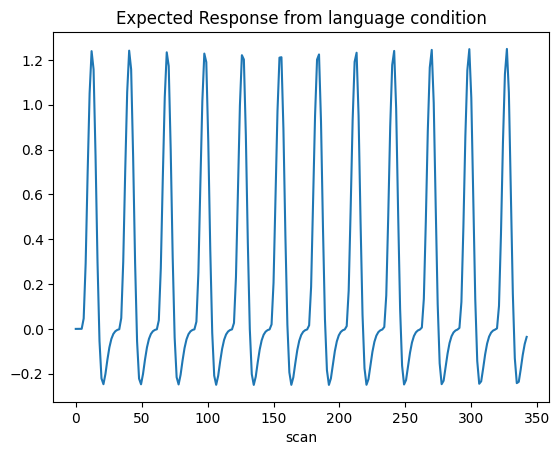

In [15]:

from nilearn.plotting import plot_design_matrix

# View the design matrix
design_matrix = model1.design_matrices_[0]


#Plot the design matrix
plot_design_matrix(design_matrix)
plt.show()

# Also plot time series
plt.plot(design_matrix['language'])
plt.xlabel('scan')
plt.title('Expected Response from language condition')
plt.show()


We see that the design matrix contains 2 columns for the conditions + 6 for the motion parameters + 6 cosine functions for high-pass filtering + one constant/intercept.

When plotting the expected response function, we see that it looks like the hemodynamic response function.


### Defining contrasts


Next, we need to specify the `contrasts` that we are interested in. These can be defined using using vectors or the names of of the conditions, specified in the events dataframe. Sum, subtraction and scalar multiplication are allowed.


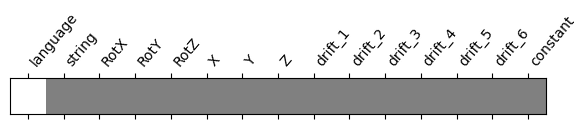

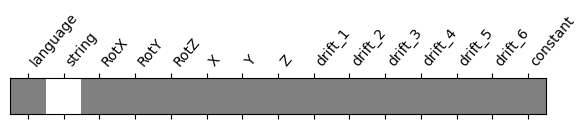

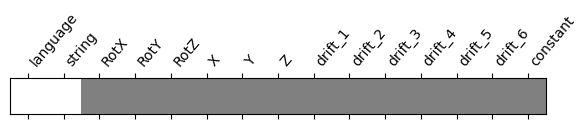

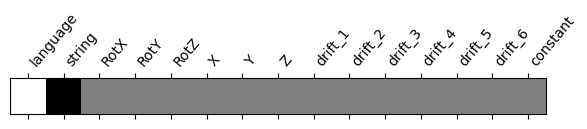

In [16]:
from nilearn.plotting import plot_contrast_matrix

#Define contrasts
contrasts=['language','string','language+string','language-string']

# Plot them to see what they look like
for contrast in contrasts:
    plot_contrast_matrix(contrast, design_matrix=design_matrix)

### Setting the significance threshold
To display the results, we will set a statistical threshold. Conventionally p<0.001, uncorrected for multiple comparisons has been used. 

It often gives a good picture of what is at play in the data, but should be interpreted with caution, due to the fact that it is uncorrected.

In [17]:
from scipy.stats import norm
p001_unc = norm.isf(0.001)

### Plotting the results
Now, we will plot the results from the different contrasts. We will do so using the mean of the functional data as background.

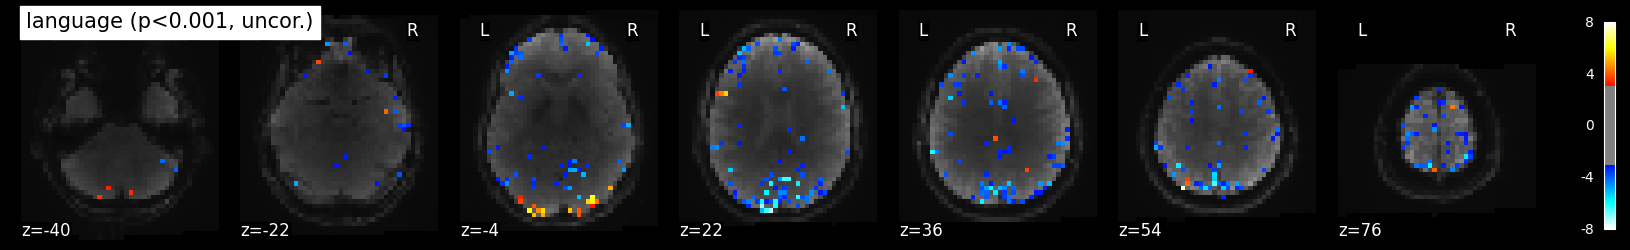

/work/798873/virt_env/lib/python3.10/site-packages/nilearn/reporting/_get_clusters_table.py:338: UserWarning: Attention: No clusters with stat higher than 3.090232306167813
  warnings.warn(


Empty DataFrame
Columns: [Cluster ID, X, Y, Z, Peak Stat, Cluster Size (mm3)]
Index: []


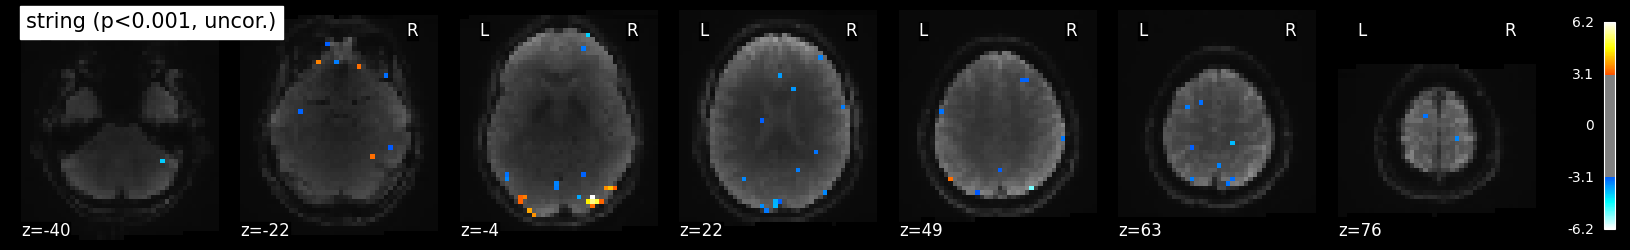

/work/798873/virt_env/lib/python3.10/site-packages/nilearn/reporting/_get_clusters_table.py:338: UserWarning: Attention: No clusters with stat higher than 3.090232306167813
  warnings.warn(


Empty DataFrame
Columns: [Cluster ID, X, Y, Z, Peak Stat, Cluster Size (mm3)]
Index: []


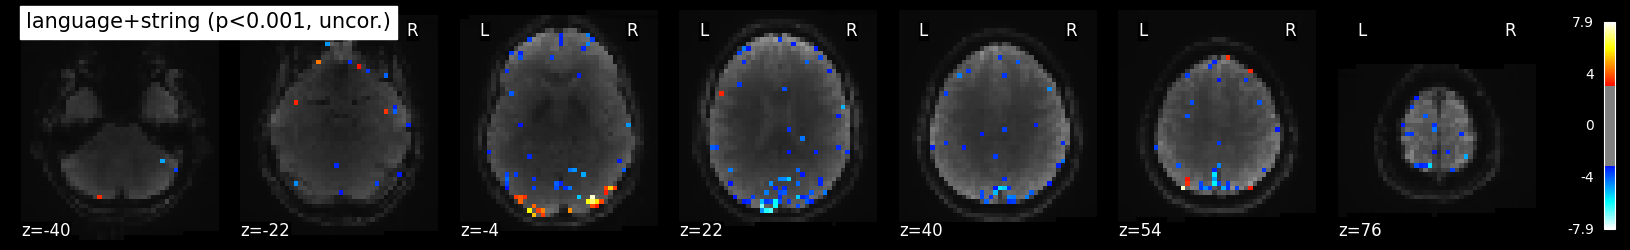

  Cluster ID     X      Y     Z  Peak Stat Cluster Size (mm3)
0          1 -21.5 -102.5   0.0   7.910807               2004
1         1a -35.0  -98.0   0.0   6.362248                   
2         1b -17.0 -102.5 -13.5   5.057250                   


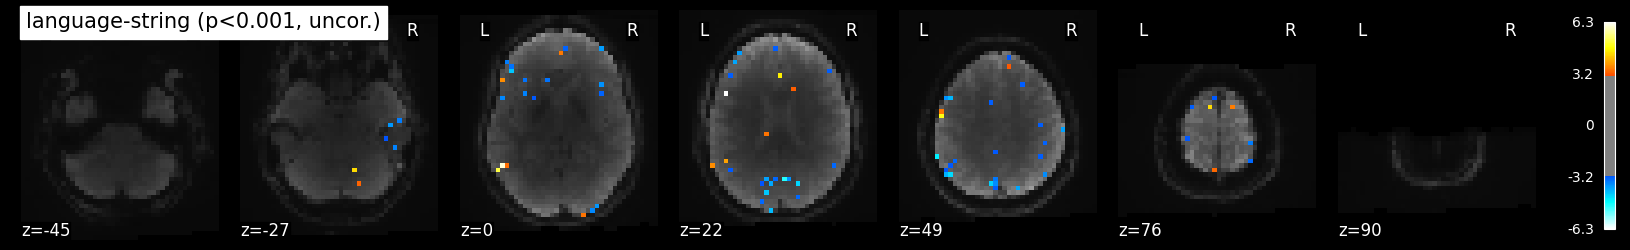

Empty DataFrame
Columns: [Cluster ID, X, Y, Z, Peak Stat, Cluster Size (mm3)]
Index: []


/work/798873/virt_env/lib/python3.10/site-packages/nilearn/reporting/_get_clusters_table.py:338: UserWarning: Attention: No clusters with stat higher than 3.090232306167813
  warnings.warn(


In [18]:
from nilearn.plotting import plot_stat_map
from nilearn.reporting import get_clusters_table
from nilearn.image import mean_img

# Make a mean image for display purposes
mean_img_ = mean_img(imgs1)

for contrast in contrasts:
    z_map = model1.compute_contrast(contrast, output_type='z_score')


    titlex=''.join([contrast, ' ', '(p<0.001, uncor.)'])
    plot_stat_map(z_map, bg_img=mean_img_, threshold=p001_unc,
              display_mode='z',  black_bg=True,
              title=titlex)
    plt.show()
    
    # Make a table of cluster coordinates.
    table = get_clusters_table(z_map, stat_threshold=p001_unc,
                           cluster_threshold=20)
    print(table)
    


### Make a report of the results

We can also use the [`make_glm_report`](https://nistats.github.io/modules/generated/nistats.reporting.make_glm_report.html) function to make a report in one go. This report is generated as a HTML document, which can only be viewed in a notebook.

This also includes a table of cluster coordinates.


In [19]:
from nilearn.reporting import make_glm_report
#Generate a report
report = make_glm_report(model1,
                         contrasts=contrasts,
                         threshold=p001_unc,
                         bg_img=mean_img_,
                         )
#Display report in HTML format
report

drift_model,cosine
drift_order,1
fir_delays,[0]
high_pass (Hz),0.01
hrf_model,glover
noise_model,ar1
scaling_axis,0
signal_scaling,0
slice_time_ref,0.0
smoothing_fwhm,None
standardize,False


### Making an F contrast


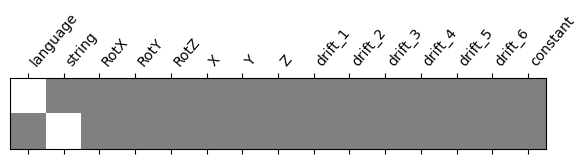

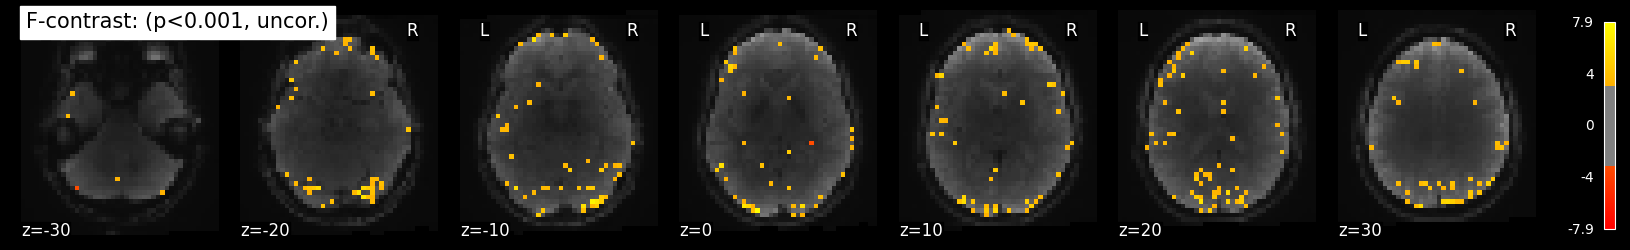

  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1  14.5 -71.0  63.0   5.821624               2187
1         1a  -3.5 -84.5  45.0   5.579644                   
2         1b   5.5 -80.0  54.0   4.978729                   
3          2  19.0 -89.0  22.5   5.759730               2916
4         2a  10.0 -93.5  31.5   5.622837                   
5         2b  19.0 -98.0  27.0   5.553737                   
6         2c  10.0 -93.5  18.0   5.221675                   


In [20]:
import numpy as np

#create a contrast matrix for the F-contrast, spanning the two first columns in the design matrix
effects_of_interest =np.identity(design_matrix.shape[1])[[0,1],:]

#Let's see what it looks like
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

#Similar to above, we will compute the effect
z_map = model1.compute_contrast(effects_of_interest,
                                  output_type='z_score')

#And plot the results using an overlay
plot_stat_map(z_map, bg_img=mean_img_, threshold=p001_unc, cmap='autumn',
              display_mode='z',  black_bg=True,cut_coords=[-30,-20,-10,0,10,20,30],
              title='F-contrast: (p<0.001, uncor.)')
plt.show()
    
# Make a table of cluster coordinates.
table = get_clusters_table(z_map, stat_threshold=p001_unc,
                           cluster_threshold=20)
print(table)

### Analysing all single participants in one go and plotting them

Now, we will make a loop which fits all the models and plots the results. We will focus on the *language-string* contrast.



Fitting participant: 03, (0/10)
Fitting participant: 08, (1/10)
Fitting participant: 05, (2/10)
Fitting participant: 07, (3/10)
Fitting participant: 04, (4/10)
Fitting participant: 01, (5/10)
Fitting participant: 10, (6/10)
Fitting participant: 06, (7/10)
Fitting participant: 09, (8/10)
Fitting participant: 02, (9/10)


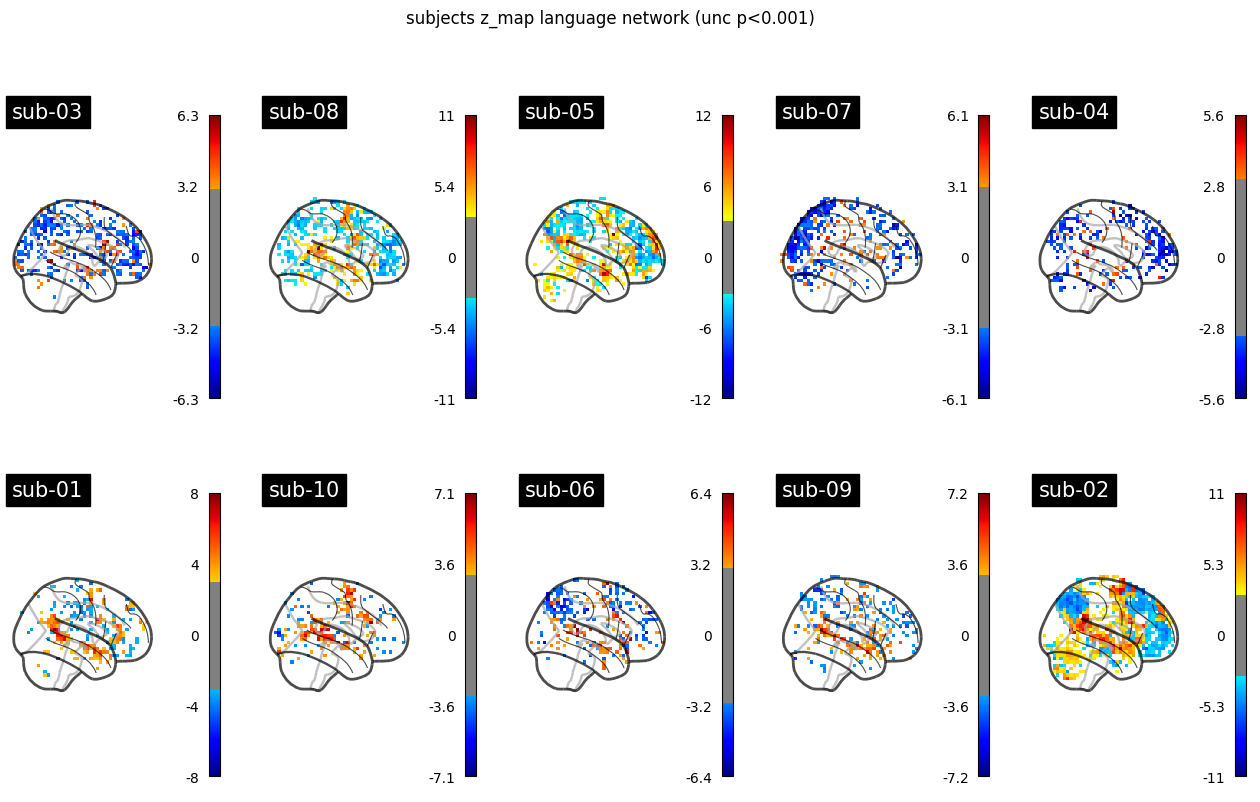

In [24]:
from nilearn import plotting
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 9))
model_and_args = zip(models, models_run_imgs, models_events, models_confounds)
for m_idx, (model, imgs, events, confounds) in enumerate(model_and_args):
    print("Fitting participant: %s, (%s/%s)" % (model.subject_label,m_idx+1,len(models)))
    # fit the GLM, recall that the model variable is a FirstLevelModel object
    model.fit(imgs, events, confounds)
    # compute the contrast of interest and make a map of z-values
    zmap = model.compute_contrast('language-string')
    #Plot each thresholded analysis
    plotting.plot_glass_brain(zmap, cmap='jet',colorbar=True, threshold=p001_unc,
                              title=('sub-' + model.subject_label),
                              axes=axes[int(m_idx / 5), int(m_idx % 5)],
                              plot_abs=False, display_mode='x')
fig.suptitle('subjects z_map language network (unc p<0.001)')
plotting.show()

Note that the single subject results look very different, although one can also see patterns in most participants that look similar.

To investigate the degree of overlap in the data, we will perform a 2nd level analysis, where the contrast estimates for each individual participant will enter as data in a new statistical test.



## Second level (group) model estimation


In experiments with repeated measurements across participants, data are usually (in non-fMRI contexts) analyzed in a single multilevel GLM by "concatenating" the data. In fMRI, we usually don't take this approach due to the computational burden. Instead we use the summary statistics approach, which analyzes each partcipant separately and subsequently aggregates the data in a second, participant-level GLM. 

![summary_statistics_approach.png](images/summary_statistics_approach.png)


Basically, this amounts to doing the same thing as we did with the participant-level analyses, but this time, the results from our participant-level analyses ($c\hat{\beta}^{*}$) across different subjects will become our target ($y^{\dagger}$). We use the "dagger" ($^{\dagger}$) superscript to denote that the mathematical terms belong to the group-level model.

To reiterate, the results from our participant-level analyses ($c\hat{\beta}^{*}$), become our dependent variable in our group-level analysis ($y^{\dagger}$):

\begin{align}
y^{\dagger} = c\hat{\beta}^{*}
\end{align}

Again, the group-level represents a GLM with a particular design matrix ($\mathbf{X}^{\dagger}$) and parameters ($\beta^{\dagger}$):

\begin{align}
y^{\dagger} = \mathbf{X}^{\dagger}\beta^{\dagger} + \epsilon^{\dagger}
\end{align}

And the group-level parameters can be estimated with OLS:

\begin{align}
\hat{\beta}^{\dagger} = (\mathbf{X}^{\dagger\ T} \mathbf{X}^{\dagger})^{-1}\mathbf{X}^{\dagger}y^{\dagger}
\end{align}

The parameter estimation procedure (i.e., estimating $\hat{\beta}^{\dagger}$) is the same as for individual participants, and using only one summary statistic data-point (e.g. beta image or contrast image) per participant, has the advantage of effectively making sure that we treat participants as random effects. 


### Making a 2nd level model in Nilearn
We just have to provide the list of fitted `FirstLevelModel` objects
to the `SecondLevelModel` object for estimation. We can do this because
all subjects share a similar design matrix (same variables reflected in
column names).

In [25]:
from nilearn.glm.second_level import SecondLevelModel
#We will simply add the models estimated above to the second level
second_level_input = models

Note that we apply a smoothing of 8mm to allow for better overlap of data.



In [26]:
#Adding the smoothing parameter
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_input)

Computing contrasts at the second level is as simple as at the first level.
Since we are not providing confounders we are performing a one-sample test
at the second level with the images determined by the specified first level
contrast.



In [27]:
zmap_g = second_level_model.compute_contrast(
    first_level_contrast='language-string')


### Plotting whole brain results
We will use twe different methods to display results: `plot_glass_brain` yields a transparent view of the whole brain as seen from three angles: `plot_stat_map` presents the results on non-transparent brain slices.



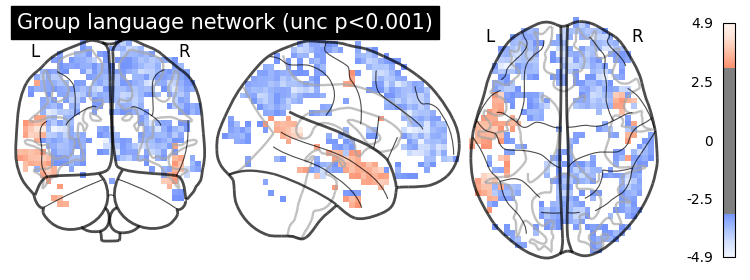

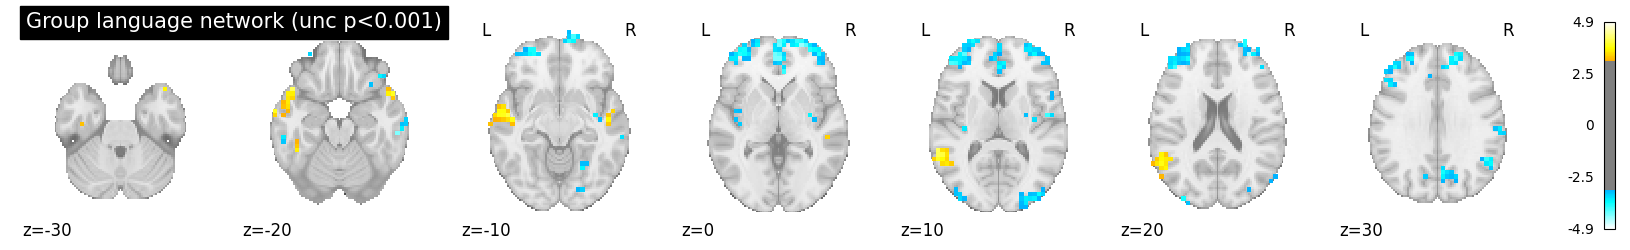

In [28]:
plotting.plot_glass_brain(zmap_g, cmap='blue_red',colorbar=True, threshold=p001_unc,
                          title='Group language network (unc p<0.001)',
                          plot_abs=False)
plt.show()

plot_stat_map(zmap_g, cmap='cold_hot',threshold=p001_unc, cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='Group language network (unc p<0.001)')
plt.show()

The group level contrast reveals a slightly left lateralized effect, primarily in something that looks like temporal
language areas (based solely on eye-balling). This is by thresholding the z-statistic image with an uncorrected false positive rate < .001. This means that 1/1000 voxels will be activated due to chance.

In [38]:
from nilearn.glm import threshold_stats_img
thresholded_map, threshold = threshold_stats_img(
    zmap_g, alpha=.001, height_control='fpr')

#Create some output
print('The uncorrected p<.001 z-score threshold is %.3g' % threshold)
print('The voxel dimensions of the brain map is: (%s, %s, %s)' % (zmap_g.shape))
vxcount=zmap_g.shape[0]*zmap_g.shape[1]*zmap_g.shape[2]
print('There are %s voxels in the map, with a fpr of 0.001, we should thus expect to see %s false possitive voxels' % (vxcount, vxcount/1000))


The uncorrected p<.001 z-score threshold is 3.29
The size of the brain map is: (45, 53, 43)
There are 102555 voxels in the map, with a fpr of 0.001, we should thus expect to see 102.555 false possitive voxels


### Correcting for multiple comparisons

Nilearn allows you to make different corrections for multiple comparisons.
Here, we will try correcting for the false discovery rate (FDR) and the familiy-wise error rate (FWER)

The FDR=.05 threshold is 2.74
The p<.05 Bonferroni-corrected threshold is 4.71


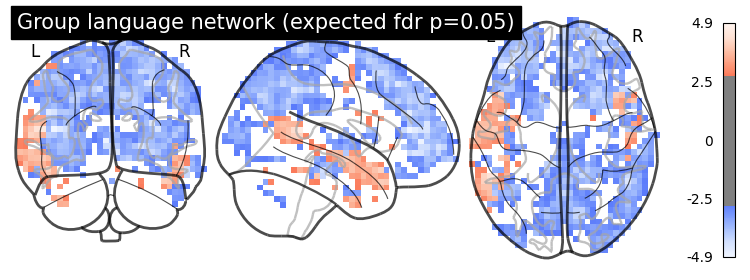

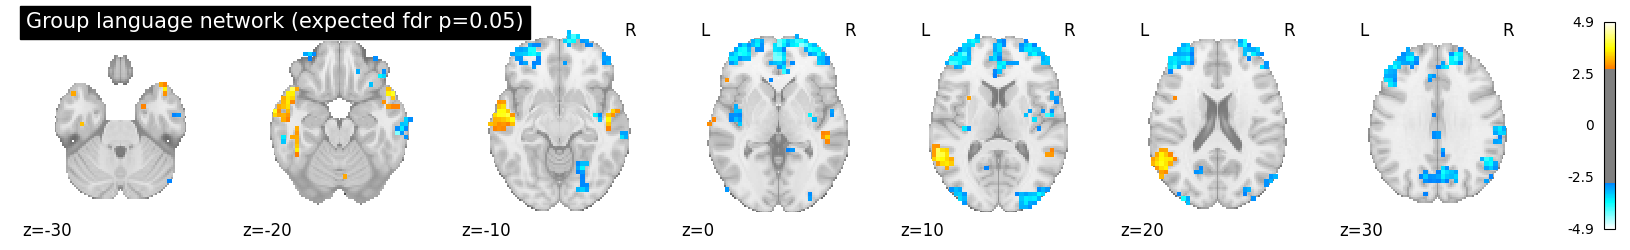

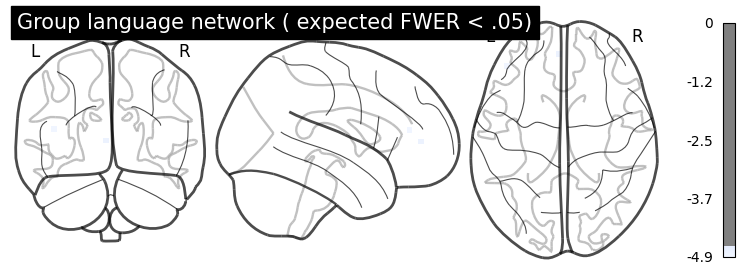

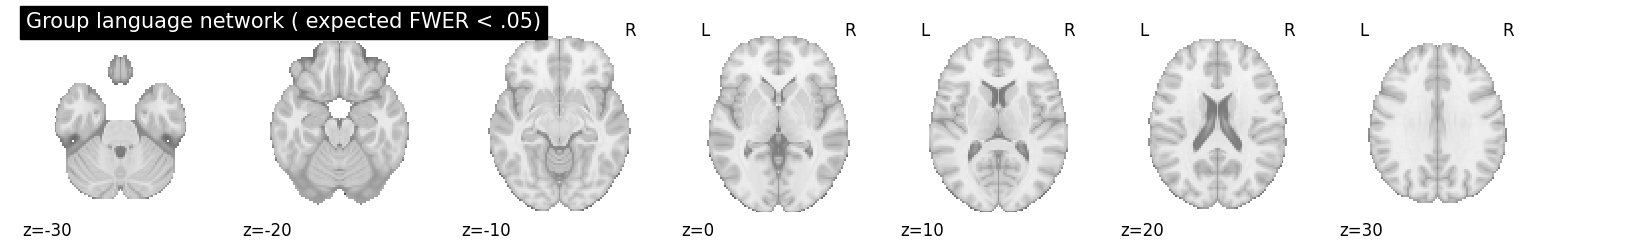

In [39]:
thresholded_map2, threshold2 = threshold_stats_img(
    zmap_g, alpha=.05, height_control='fdr')
print('The FDR=.05 threshold is %.3g' % threshold2)

thresholded_map3, threshold3 = threshold_stats_img(
    zmap_g, alpha=.05, height_control='bonferroni')
print('The p<.05 Bonferroni-corrected threshold is %.3g' % threshold3)


plotting.plot_glass_brain(thresholded_map2, cmap='blue_red',colorbar=True, threshold=threshold2,
                          title='Group language network (expected fdr p=0.05)',
                          plot_abs=False)
plt.show()

plot_stat_map(thresholded_map2, cmap='cold_hot', threshold=threshold2,cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='Group language network (expected fdr p=0.05)')
plt.show()

plotting.plot_glass_brain(thresholded_map3, cmap='blue_red',colorbar=True, threshold=threshold3,
                          title='Group language network ( expected FWER < .05)',
                          plot_abs=False)
plt.show()

plot_stat_map(thresholded_map3, cmap='cold_hot', threshold=threshold3,cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='Group language network ( expected FWER < .05)')
plt.show()

As can be seen, the fdr correction may be too lenient, and the FWE correction may be too stringent.

## Non-parametric permutation methods for calculating corrected p-values

Based on [this](https://nilearn.github.io/dev/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html#sphx-glr-auto-examples-05-glm-second-level-plot-second-level-one-sample-test-py) example.

Permutation tests are a class of non-parametric methods. They were pioneered by Fisher (1935) and Pitman (1937). Fisher demonstrated that the null hypothesis could be tested simply by observing, after permuting observations, how often the difference between means would exceed the difference found without permutation, and that for such test, no normality would be required.


![permutation_stats.jpg](images/permutation_stats.jpg)

If we are comparing two samples (e.g. `treatment` and `control`), we can calculate the effect, we get when shuffling the category labels.

![Permutation_test_example_animation.gif](images/Permutation_test_example_animation.gif)
Source:[Wikipedia](https://en.wikipedia.org/wiki/Permutation_test)

The percentage of values we get that are bigger than our original value, represents the probability that our value comes from the null-distribution.

The one-sided p-value of the test is calculated as the proportion of sampled permutations where the difference in means was greater than ${\displaystyle T_{\text{obs}}}$. 
The two-sided p-value of the test is calculated as the proportion of sampled permutations where the absolute difference was greater than 
${\displaystyle |T_{\text{obs}}|}$.

When conducting a one-sample group analysis with fMRI-data, we are testing ${\displaystyle H_{0}:T=0}$, i.e.  if the effect of any given voxel is larger than zero. We can obtain a null-distribution by estimating the effect N times, while randomly flipping the sign on each datapoint.


### Making a an image for comparison
Before we make the permutation test, we'll calculate an image from the parametric analysis for comparison. We will use the negative log of the p-value as a measure.



In [40]:
import numpy as np
from nilearn.image import get_data, math_img

#Get an image of p-values
p_val = second_level_model.compute_contrast(first_level_contrast='language-string',output_type='p_value')
# Get the number of voxels in the image
n_voxels = np.sum(get_data(second_level_model.masker_.mask_img_))
# Making an image with significant values, correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img(
    '-np.log10(np.minimum(1, img * {}))'.format(str(n_voxels)),
    img=p_val,
)

#Check image shape
print(neg_log_pval.shape)

(45, 53, 43)


<string>:1: RuntimeWarning: divide by zero encountered in log10


### Next, we perform the permutations.

In [41]:
from nilearn.glm.second_level import non_parametric_inference
# n_perm=1000 for the sake of time. Ideally, this should be 10,000, but the upper limit on permutations is 2 to the power of N.
n_perm=1000

design_matrix = pd.DataFrame(
    [1] * len(second_level_input),
    columns=['intercept'],
)

#Calculate p-values using permutation
out_dict = non_parametric_inference(
    second_level_input,
    design_matrix=design_matrix,
    first_level_contrast='language-string',
    model_intercept=True,
    n_perm=n_perm,  
    two_sided_test=False,
    smoothing_fwhm=8.0,
    n_jobs=1,
        
    
)

Now let's plot the permutation results and compare with the bonferroni corrected effect. 

Note that effects are now negative log of the p-value, so we will have to take that into consideration when plotting.

/work/798873/virt_env/lib/python3.10/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


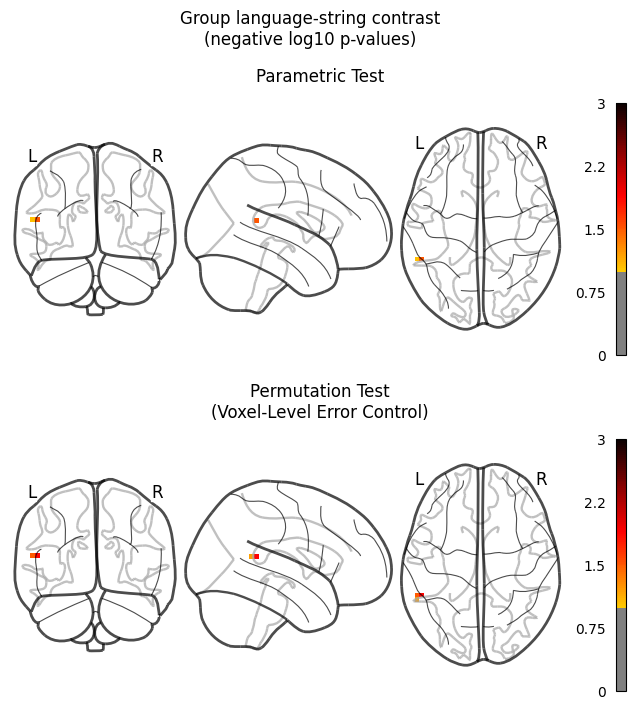

In [42]:

# Prepare thresholds for plotting

threshold_log = round(-np.log10(1 / 20))  # p < 0.05 
vmax = round(-np.log10(1 / n_perm)) # minimal p-value possible with the number of permuations

cut_coords = [0]

#Prepare images to plot
IMAGES = [
    neg_log_pval,
    out_dict
]
TITLES = [
    'Parametric Test',
    'Permutation Test\n(Voxel-Level Error Control)',
]

#Make loop with plots
fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=1)
img_counter = 0
i_row=0
for j_row in range(2):
        ax = axes[j_row]     
        plotting.plot_glass_brain(
            IMAGES[img_counter],
            colorbar=True,
            vmax=vmax,
            plot_abs=False,
            cut_coords=cut_coords,
            threshold=threshold_log,
            figure=fig,
            axes=ax,
        )

        
        ax.set_title(TITLES[img_counter])
        img_counter += 1


fig.suptitle('Group language-string contrast\n(negative log10 p-values)')
plt.show()

As you may be able to see, the permutation test is slightly more sensitive. 

A big advantage is that permutation tests are also more intuitive than many of the complex methods for multiple comparisons correction on the market.